### Assignment: Advanced Regression

Assignment Part-I
A US-based housing company named Surprise Housing has decided to enter the Australian market.
The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

* Which variables are significant in predicting the price of a house, and

* How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

__Business Goal__
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,PowerTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')
%matplotlib inline


### Performing baisc checks in the dataset

In [2]:
house_price=pd.read_csv('train.csv')
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
print(house_price.size)
print(house_price.shape)

118260
(1460, 81)


In [5]:
house_price.describe([0.25,0.50,0.75,0.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
99%,1445.410000,190.000000,141.000000,37567.640000,10.000000,9.000000,2009.000000,2009.000000,791.920000,1572.410000,...,505.460000,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,12.000000,2010.000000,442567.010000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Checking the dataset for the amount of nulls present

In [6]:
print('Percentage of Missing Values in each column is as follows:')
print(round(house_price.isnull().sum()/len(house_price.index)*100,2).sort_values(ascending=False)[round(house_price.isnull().sum()/len(house_price.index),2) > 0 ] )

Percentage of Missing Values in each column is as follows:
PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
dtype: float64


18 features have missing values, out of which 5 features have more than 45% missing values.

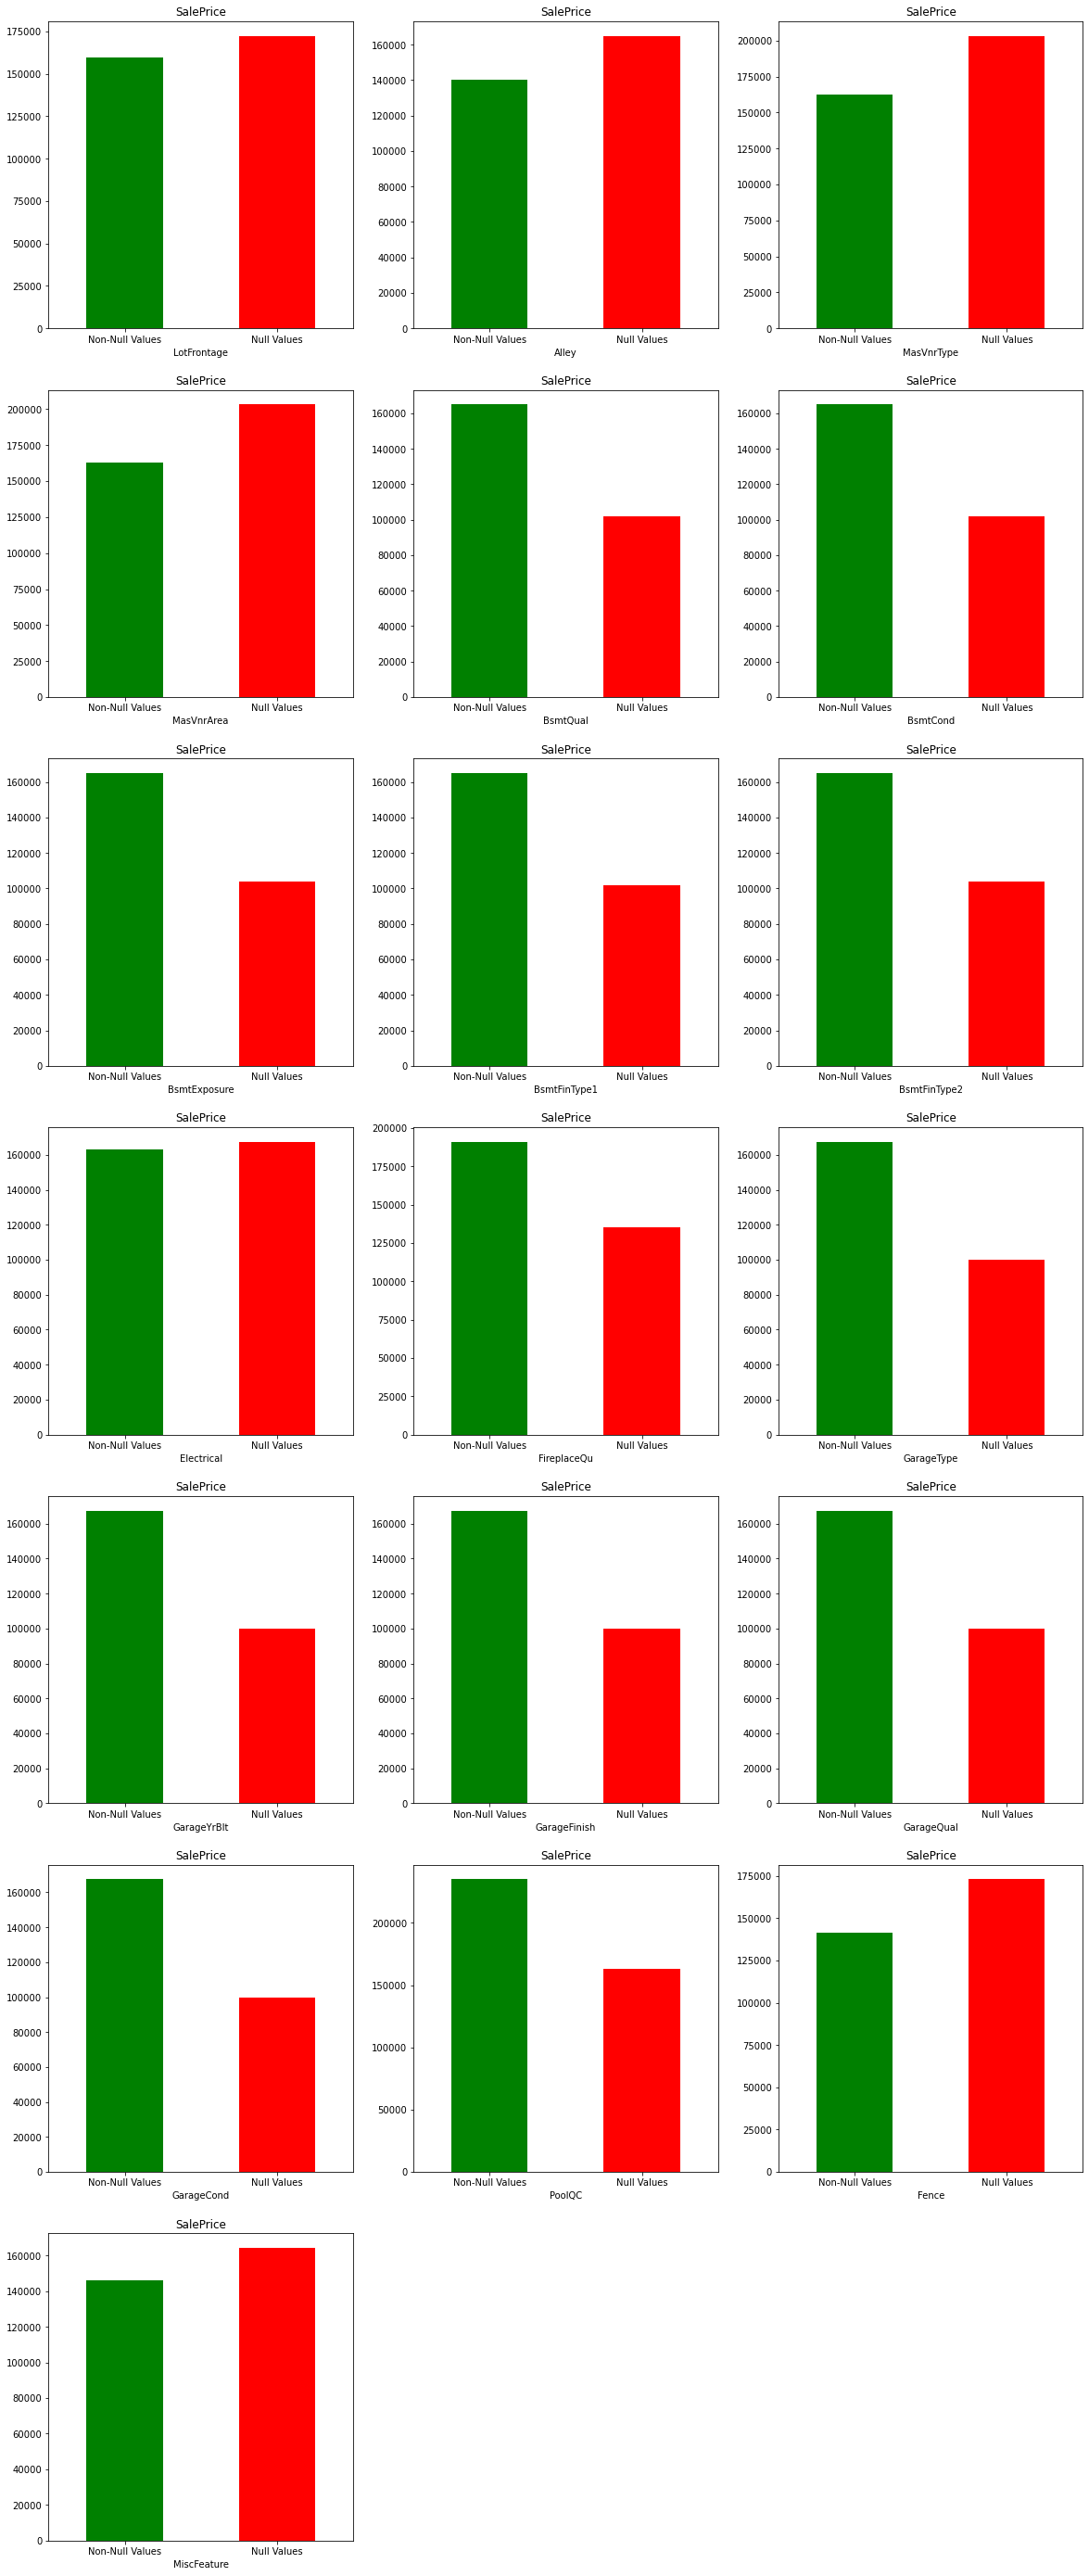

In [7]:
# Checking if NaN Values have any impact on the Sale Price or not
nan_col = []
for i in house_price.columns:
    if house_price[i].isnull().sum() > 0:
        nan_col.append(i)
house_price_copy = house_price.copy()    
fig,axs= plt.subplots(7,3,figsize=(20,50),squeeze=True)
for i,ax in zip(nan_col,axs.flatten()):    
    house_price_copy[i] = np.where(house_price_copy[i].isnull(), 'Null Values', 'Non-Null Values') 
    house_price_copy.groupby(i)['SalePrice'].median().plot.bar(color = list('gr'),rot=0,ax=ax,subplots=True)
axs[6,1].set_axis_off()    
axs[6,2].set_axis_off() 
plt.show()

In [8]:
# Checking the number of numerical features and the number of categorical features
numerical_col = []
categorical_col = []
for i in house_price.columns:
    if house_price[i].dtypes != 'O':
        numerical_col.append(i)
    else:
        categorical_col.append(i)
print('There are', len(numerical_col) ,'numerical features in the dataset')
print('There are', len(categorical_col), 'categorical features in the dataset')

There are 38 numerical features in the dataset
There are 43 categorical features in the dataset


Text(0.5, 1.0, 'House Price vs YearSold')

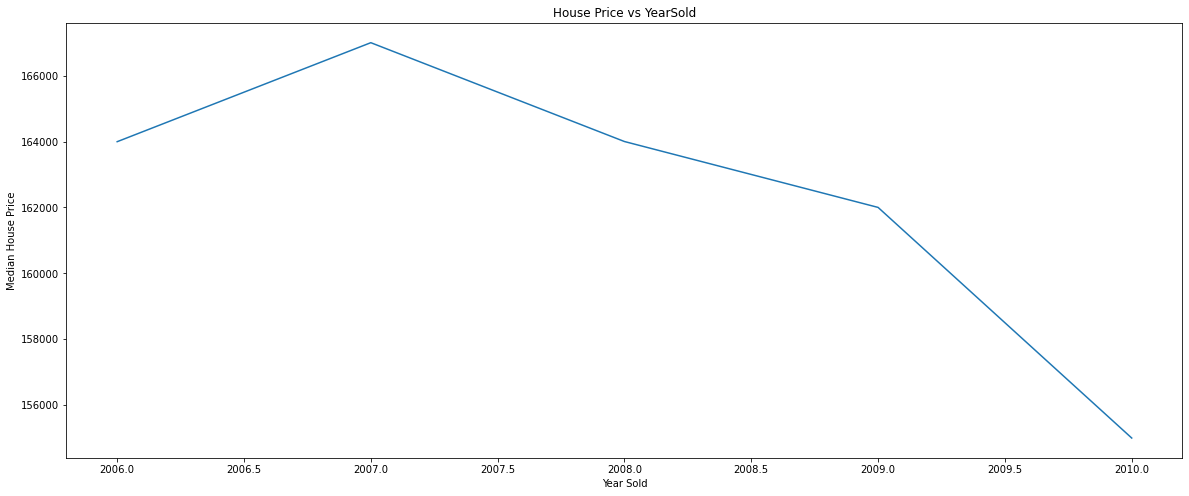

In [9]:
# Chekcing if the median price changes with the year sold
plt.figure(figsize=(20, 8))
house_price['YrSold'] = house_price['YrSold']
house_price.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('Median House Price')
plt.title("House Price vs YearSold")

Average price decreases from 2007 to 2008 and futher it Avg price decrease from 2008 to 2009. from 2009 house price dropped significantly.

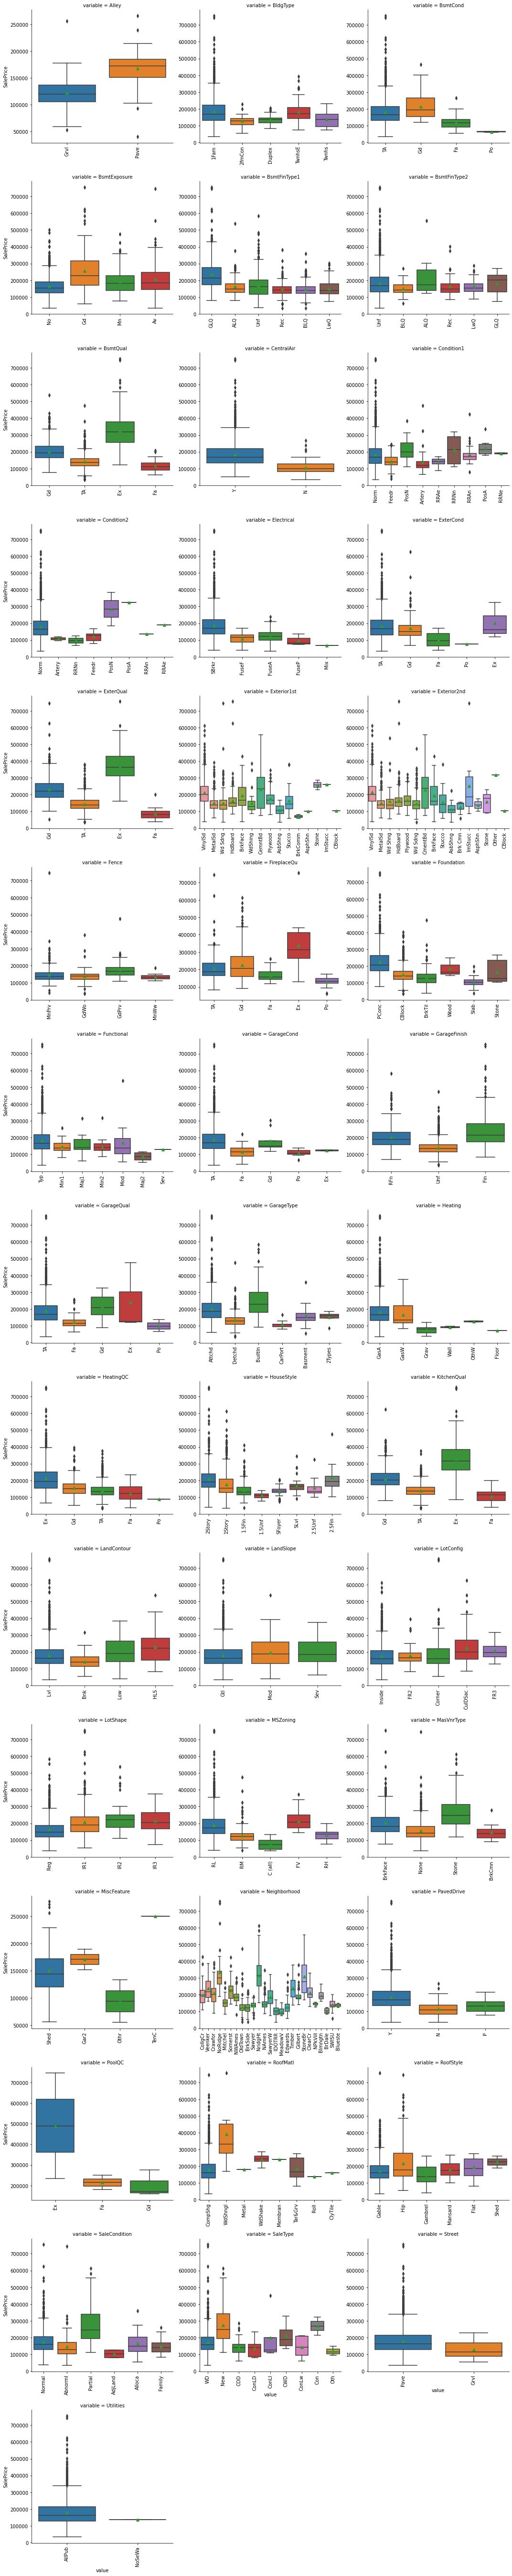

In [10]:
# Plotting Categorical Features with Sale Price
def facetgrid_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y,orient='v',showmeans=True)
    x=plt.xticks(rotation=90)
    
cat = house_price.select_dtypes(exclude=['int64','float64'])
f = pd.melt(house_price, id_vars=['SalePrice'], value_vars=sorted(house_price[cat.columns]))
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(facetgrid_boxplot, "value", "SalePrice")


There are a few outliers which we handle in the feature engineering section by capping them to a lower percentile

In [11]:
# Dropping ID Columns from dataset since it is useless in the prediction usecase
house_price.drop('Id', axis=1, inplace=True)

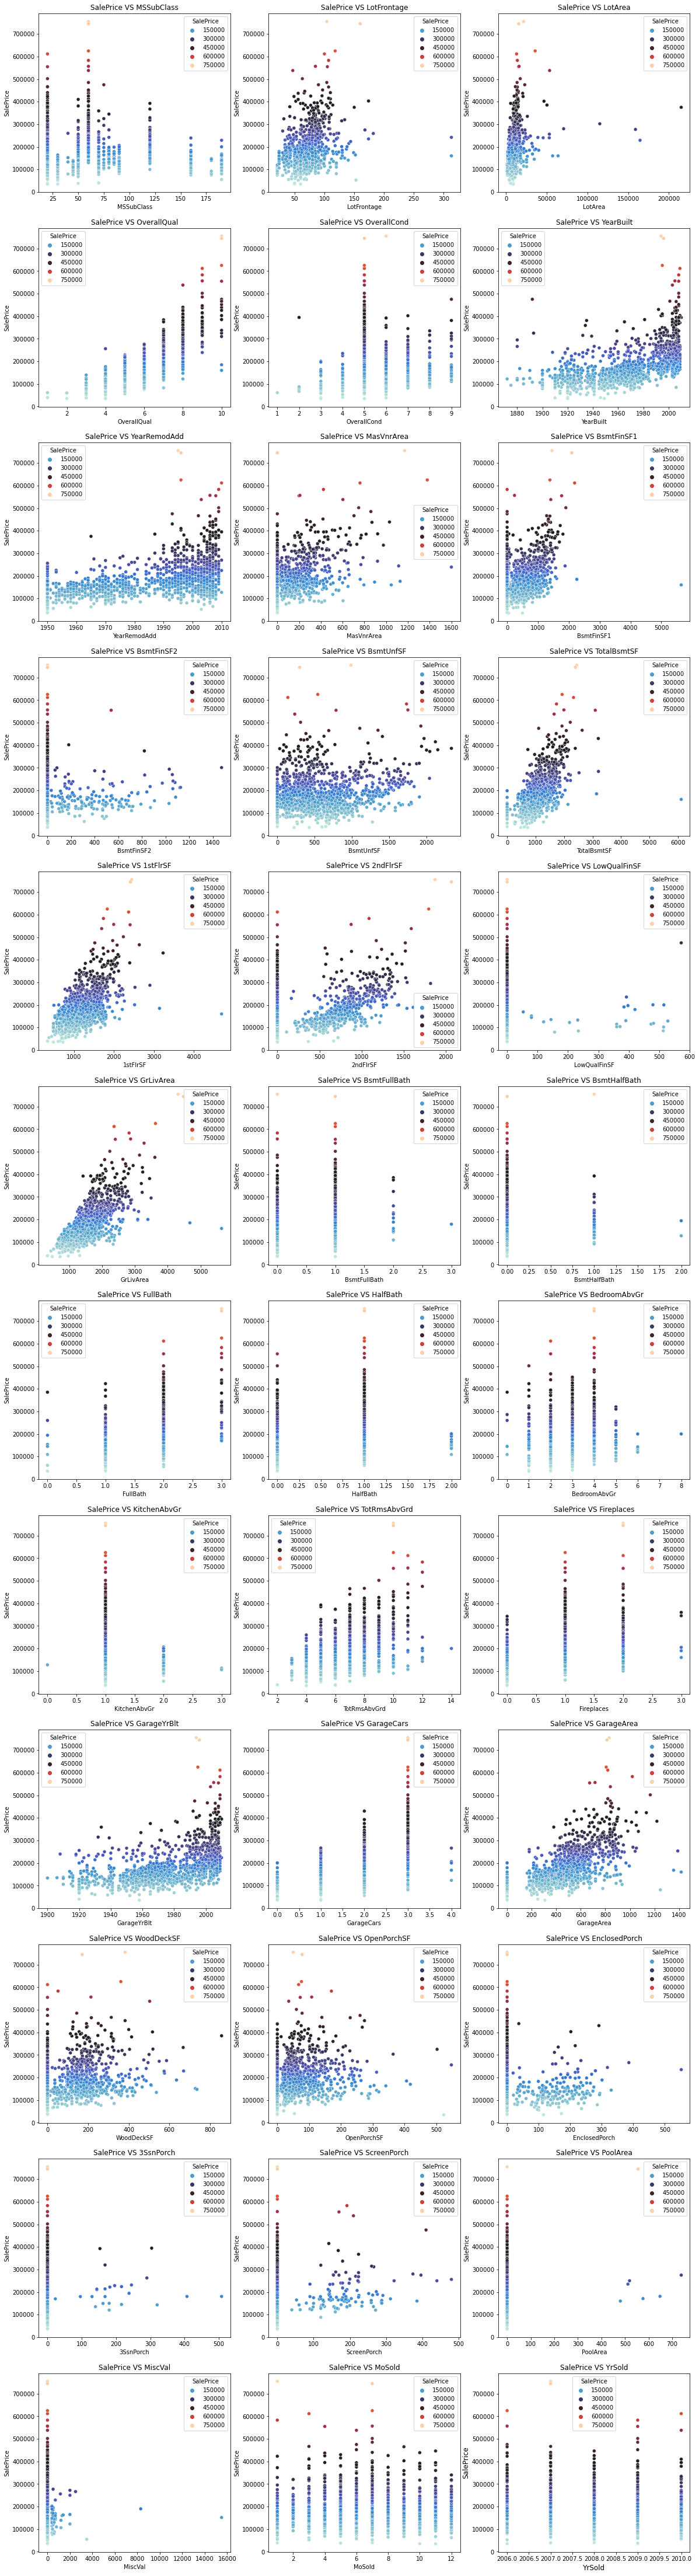

In [12]:
# Checking the same with a pairplot 
house_price_num=house_price.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(12,3,figsize=(20,80))
for i,ax in zip(house_price_num.columns,axs.flatten()):
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice',data=house_price_num,ax=ax,palette='icefire')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

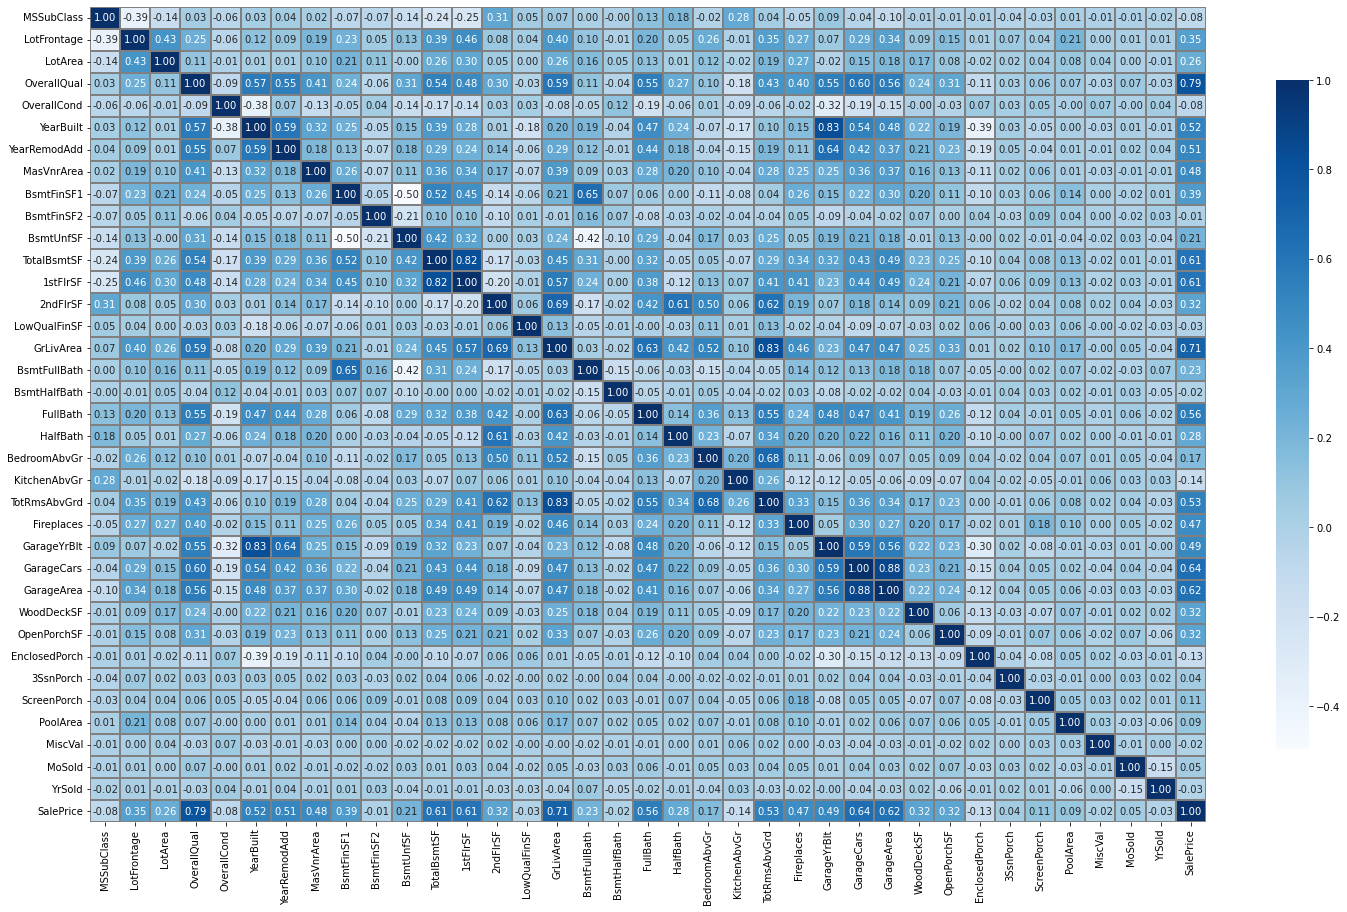

In [13]:
plt.figure(figsize=(25,15))
sns.heatmap(house_price[list(house_price.dtypes[house_price.dtypes!='object'].index)].corr(),annot=True,fmt='.2f',cmap='Blues',cbar_kws={"shrink": .82},
                  linewidths=0.1, linecolor='gray')
plt.show()

There are few highly correlated features available. we need eliminated them

### Data Preparation 

In [14]:
# Converting the Year to String since they are categorical features and should not be treated as numerical features
house_price['YearBuilt_Old'] = house_price.YearBuilt.max()-house_price.YearBuilt
house_price['YearRemodAdd_Old'] = house_price.YearRemodAdd.max()-house_price.YearRemodAdd
house_price['GarageYrBlt_Old'] = house_price.GarageYrBlt.max()-house_price.GarageYrBlt
house_price['YrSold_Old'] = house_price.YrSold.max()-house_price.YrSold
house_price[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].sample(10)


,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
715,1974,1974,1974.0,2009,36,36,36.0,1
331,1958,1992,1958.0,2007,52,18,52.0,3
192,1999,1999,1999.0,2009,11,11,11.0,1
928,2001,2001,2001.0,2009,9,9,9.0,1
824,2006,2006,2006.0,2006,4,4,4.0,4
1096,1914,2006,NaN,2007,96,4,NaN,3
1033,2002,2002,2002.0,2006,8,8,8.0,4
1107,2006,2006,2006.0,2006,4,4,4.0,4
389,2007,2008,2008.0,2008,3,2,2.0,2
251,2006,2007,2006.0,2007,4,3,4.0,3


In [15]:
house_price.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns',inplace=True)

In [16]:
house_price[['YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].sample(10)

,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
1273,51,4,51.0,2
875,3,3,3.0,3
439,90,10,5.0,1
994,4,3,2.0,1
476,13,12,13.0,2
916,61,60,52.0,4
282,3,2,2.0,1
174,24,24,24.0,2
586,92,10,49.0,2
947,8,7,8.0,3


In [17]:
house_price.shape

(1460, 80)

In [18]:
house_price.MSSubClass.dtype

dtype('int64')

### Handling missing values

In [19]:
# getting list of columns with Null Values again
print('Percentage of Missing Values in each column is as follows:')
print(round(house_price.isnull().sum()/len(house_price.index)*100,2).sort_values(ascending=False)[round(house_price.isnull().sum()/len(house_price.index),2) > 0 ] )

Percentage of Missing Values in each column is as follows:
PoolQC             99.52
MiscFeature        96.30
Alley              93.77
Fence              80.75
FireplaceQu        47.26
LotFrontage        17.74
GarageYrBlt_Old     5.55
GarageQual          5.55
GarageCond          5.55
GarageFinish        5.55
GarageType          5.55
BsmtExposure        2.60
BsmtFinType2        2.60
BsmtFinType1        2.53
BsmtCond            2.53
BsmtQual            2.53
MasVnrArea          0.55
MasVnrType          0.55
dtype: float64


In [20]:
drop_col=pd.DataFrame(round(house_price.isnull().sum()/len(house_price.index)*100,2).sort_values(ascending=False)[round(house_price.isnull().sum()/len(house_price.index),2) > 0 ])

In [21]:
drop_remove_hi=drop_col[drop_col[0]>20].index.values

In [22]:
####Dropping Highest percentage of missing values >20%

house_price.drop(drop_remove_hi,axis=1,inplace=True)

In [23]:
house_price.shape

(1460, 75)

In [24]:
# getting list of columns with Null Values again
print('Percentage of Missing Values in each column is as follows:')
print(round(house_price.isnull().sum()/len(house_price.index)*100,2).sort_values(ascending=False)[round(house_price.isnull().sum()/len(house_price.index),2) > 0 ] )

Percentage of Missing Values in each column is as follows:
LotFrontage        17.74
GarageYrBlt_Old     5.55
GarageType          5.55
GarageQual          5.55
GarageCond          5.55
GarageFinish        5.55
BsmtFinType2        2.60
BsmtExposure        2.60
BsmtQual            2.53
BsmtCond            2.53
BsmtFinType1        2.53
MasVnrType          0.55
MasVnrArea          0.55
dtype: float64


### Imputing missing value

In [25]:

house_price.GarageYrBlt_Old.fillna(-1,inplace=True)# Notice imputing GarageYrBlt_Old with -1 as these house donot have garage
house_price.GarageType.fillna('Attchd',inplace=True)
house_price.GarageQual.fillna('TA',inplace=True)
house_price.GarageCond.fillna('TA',inplace=True)

house_price.GarageFinish.fillna('Unf',inplace=True)
house_price.BsmtFinType2.fillna('Unf',inplace=True)
house_price.BsmtExposure.fillna('No',inplace=True) 
house_price.BsmtQual.fillna('TA',inplace=True)

house_price.BsmtCond.fillna('TA',inplace=True)
house_price.BsmtFinType1.fillna('Unf',inplace=True)
house_price.MasVnrType.fillna('None',inplace=True)
house_price.MasVnrArea.fillna(house_price.MasVnrArea.mean(),inplace=True)



In [26]:

house_price.loc[house_price['GarageYrBlt_Old'] == 'None','GarageYrBlt_Old']
len(house_price.loc[house_price['GarageYrBlt_Old'] == -1,'GarageYrBlt_Old'])

81

In [27]:
#LotFrontage : Replacing Null value with the median of the neighbourhood
house_price['LotFrontage'] = house_price.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [28]:
# getting list of columns with Null Values again
print('Percentage of Missing Values in each column is as follows:')
print(round(house_price.isnull().sum()/len(house_price.index)*100,5).sort_values(ascending=False))

Percentage of Missing Values in each column is as follows:
Electrical      0.06849
KitchenAbvGr    0.00000
GarageCars      0.00000
GarageFinish    0.00000
GarageType      0.00000
                 ...   
ExterCond       0.00000
ExterQual       0.00000
MasVnrArea      0.00000
MasVnrType      0.00000
YrSold_Old      0.00000
Length: 75, dtype: float64


In [29]:
# Filling the Electrical 0.06% rows with the mode
house_price['Electrical'] = house_price['Electrical'].fillna(house_price['Electrical'].mode()[0])

In [30]:
# getting list of columns with Null Values again
print('Percentage of Missing Values in each column is as follows:')
print(round(house_price.isnull().sum()/len(house_price.index)*100,5).sort_values(ascending=False))

Percentage of Missing Values in each column is as follows:
MSSubClass      0.0
GarageArea      0.0
GarageFinish    0.0
GarageType      0.0
Fireplaces      0.0
               ... 
ExterCond       0.0
ExterQual       0.0
MasVnrArea      0.0
MasVnrType      0.0
YrSold_Old      0.0
Length: 75, dtype: float64


#### Some columns having same values more than 99%, hence there is no impact response variable.

In [31]:
# Identify same values presented in all the columns
# Trying to remove redundant features
def redundant_feature(df):
    redundant = []
    for i in house_price.columns:
        counts = house_price[i].value_counts()
        count_max = counts.iloc[0]
        
        if count_max / len(house_price) * 100 > 99:
            redundant.append(i)
    redundant = list(redundant)
    return redundant
duplicate_features = redundant_feature(house_price)
duplicate_features

['Street', 'Utilities', 'PoolArea']

In [32]:
house_price.drop(duplicate_features, axis=1,inplace=True)

In [33]:
house_price.shape

(1460, 72)

#### Removing Outliers

In [34]:
num_col=['GrLivArea','GarageArea','TotalBsmtSF','LotArea']
def drop_outliers(data_set):
    list = []
    for col in num_col:
        Q1 = data_set[col].quantile(.25)
        Q3 = data_set[col].quantile(.99)
        IQR = Q3-Q1
        data_set =  data_set[(data_set[col] >= (Q1-(1.5*IQR))) & (data_set[col] <= (Q3+(1.5*IQR)))] 
        
    return data_set  
house_price=drop_outliers(house_price)

In [35]:
house_price.shape

(1455, 72)

In [36]:
num_col1=[]
cat_col1=[]
for i in house_price.columns:
    if house_price[i].dtypes != 'O':
        num_col1.append(i)
    else:
        cat_col1.append(i)
print("Numerical columns:",num_col1)
print("==============================================================")
print("catgerocial columns:",cat_col1)

Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'SalePrice', 'YearBuilt_Old', 'YearRemodAdd_Old', 'GarageYrBlt_Old', 'YrSold_Old']
catgerocial columns: ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 

In [37]:
house_price[cat_col1].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [38]:
#Creating some new features based on the existing features
#Overall area for all floors and basement plays an important role, hence creating total area in square foot column
house_price['Total_sqr_footage'] = (house_price['BsmtFinSF1'] + house_price['BsmtFinSF2'] + house_price['1stFlrSF'] + house_price['2ndFlrSF'])
# Creating derived column for total number of bathrooms column
house_price['Total_Bathrooms'] = (house_price['FullBath'] + (0.5 * house_price['HalfBath']) + house_price['BsmtFullBath'] + (0.5 * house_price['BsmtHalfBath']))
#Creating derived column for total porch area 
house_price['Total_porch_sf'] = (house_price['OpenPorchSF'] + house_price['3SsnPorch'] + house_price['EnclosedPorch'] + house_price['ScreenPorch'] + house_price['WoodDeckSF'])

In [39]:
house_price.shape

(1455, 75)

In [40]:
# After creating new variable columns removes old features 
old_f=['BsmtFinSF1','BsmtFinSF2','1stFlrSF','2ndFlrSF','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','3SsnPorch',
                 'EnclosedPorch','ScreenPorch','WoodDeckSF']
house_price.drop(old_f,axis=1,inplace=True)

In [41]:
house_price.shape

(1455, 62)

In [42]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1455 non-null   int64  
 1   MSZoning           1455 non-null   object 
 2   LotFrontage        1455 non-null   float64
 3   LotArea            1455 non-null   int64  
 4   LotShape           1455 non-null   object 
 5   LandContour        1455 non-null   object 
 6   LotConfig          1455 non-null   object 
 7   LandSlope          1455 non-null   object 
 8   Neighborhood       1455 non-null   object 
 9   Condition1         1455 non-null   object 
 10  Condition2         1455 non-null   object 
 11  BldgType           1455 non-null   object 
 12  HouseStyle         1455 non-null   object 
 13  OverallQual        1455 non-null   int64  
 14  OverallCond        1455 non-null   int64  
 15  RoofStyle          1455 non-null   object 
 16  RoofMatl           1455 

In [43]:
len(house_price.dtypes != 'O')

62

##### Creating dummies(one hot encoding) for  Catherogical coulmns

In [44]:
#Creating Dummy Variables for Categorical Columns
num_col=[]
cat_col=[]
for i in house_price.columns:
    if house_price[i].dtypes != 'O':
        num_col.append(i)
    else:
        cat_col.append(i)
house_price_dummy= pd.get_dummies(house_price[cat_col])   
house_price=pd.concat([house_price,house_price_dummy],axis=1)


In [45]:
house_price.shape

(1455, 291)

In [46]:
house_price= house_price.drop(cat_col,axis=1)  

In [47]:
house_price.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1455.000000,1455.000000,1455.000000,1455.00000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,...,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000
mean,56.859107,69.954296,10059.538144,6.09622,5.575258,102.928854,567.938832,1052.243986,5.864605,1511.439863,...,0.003436,0.083162,0.002062,0.868041,0.069416,0.002749,0.008247,0.013746,0.820619,0.085223
std,42.206557,21.439524,5471.716763,1.38088,1.113722,179.546539,442.224427,417.453112,48.705402,514.565611,...,0.058540,0.276221,0.045376,0.338562,0.254247,0.052378,0.090471,0.116474,0.383803,0.279310
min,20.000000,21.000000,1300.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7537.500000,5.00000,5.000000,0.000000,223.500000,795.000000,0.000000,1128.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,70.000000,9464.000000,6.00000,5.000000,0.000000,480.000000,990.000000,0.000000,1458.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,80.000000,11568.500000,7.00000,6.000000,163.500000,809.000000,1292.000000,0.000000,1774.500000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,70761.000000,10.00000,9.000000,1600.000000,2336.000000,3206.000000,572.000000,4676.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
len(house_price.dtypes != 'O')

255

In [49]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Columns: 255 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(4), int64(22), uint8(229)
memory usage: 632.3 KB


In [50]:
house_price.select_dtypes(include=['int64','int32','float64','float32']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'MiscVal', 'MoSold', 'SalePrice',
       'YearBuilt_Old', 'YearRemodAdd_Old', 'GarageYrBlt_Old', 'YrSold_Old',
       'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf'],
      dtype='object')

### Let us check the distribution of our target variable before scaling and Splitting

#### Creating train and test dataset for validation purpose

In [51]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)
df_train,df_test=train_test_split(house_price,train_size=0.7,random_state=42)

In [52]:
print(df_train.shape)
print(df_test.shape)

(1018, 255)
(437, 255)


####  checking the distribution of response variable before scaling and Splitting

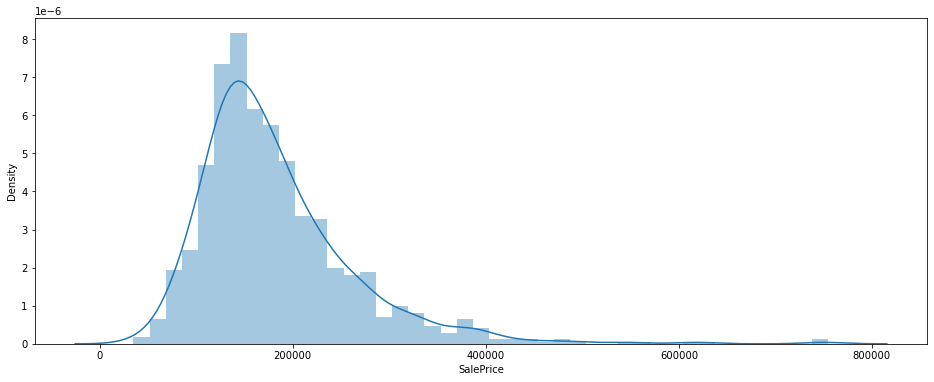

In [53]:
#Distribution of Target Variable
plt.figure(figsize=(16,6))
sns.distplot(df_train.SalePrice)
plt.show()

In [54]:
scaler=MinMaxScaler()
num_vars=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'MiscVal', 'MoSold', 'SalePrice',
       'YearBuilt_Old', 'YearRemodAdd_Old', 'GarageYrBlt_Old', 'YrSold_Old',
       'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf']
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
df_test[num_vars]=scaler.transform(df_test[num_vars])
df_train.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
467,0.294118,0.198630,0.117764,0.444444,0.750,0.162554,0.146404,0.227074,0.0,0.301704,...,0,0,0,1,0,0,0,0,1,0
474,0.588235,0.068493,0.058018,0.777778,0.500,0.000000,0.127568,0.466001,0.0,0.303547,...,0,0,0,1,0,0,0,0,1,0
1333,0.176471,0.133562,0.084940,0.444444,0.625,0.000000,0.343750,0.250468,0.0,0.236297,...,0,0,0,1,0,0,0,0,1,0
438,0.058824,0.065068,0.042902,0.444444,0.625,0.000000,0.032106,0.137243,0.0,0.082911,...,0,0,0,1,0,0,0,0,1,0
1210,0.235294,0.167808,0.142785,0.555556,0.500,0.000000,0.451627,0.329070,0.0,0.347996,...,0,0,0,1,0,0,0,0,1,0


In [55]:
df_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
500,0.823529,0.000000,0.008494,0.555556,0.5,0.206821,0.135274,0.209607,0.0,0.203593,...,0,0,0,1,0,0,0,0,1,0
1265,0.823529,0.047945,0.035056,0.666667,0.5,0.158200,0.103168,0.215533,0.0,0.257485,...,0,0,0,1,0,0,0,0,1,0
414,0.235294,0.130137,0.142929,0.666667,0.5,0.000000,0.213613,0.336868,0.0,0.406034,...,0,0,0,1,0,0,0,0,1,0
1050,0.000000,0.178082,0.110753,0.666667,0.5,0.000000,0.557363,0.406114,0.0,0.222939,...,0,1,0,0,0,0,0,0,0,1
1037,0.235294,0.167808,0.114309,0.777778,0.5,0.287373,0.451627,0.329070,0.0,0.444265,...,0,0,0,1,0,0,0,0,1,0


In [56]:
#df_train.SalePrice
df_test.SalePrice

500     0.108457
1265    0.206916
414     0.268157
1050    0.196619
1037    0.350090
          ...   
325     0.072351
1290    0.202194
728     0.104291
541     0.295931
135     0.193168
Name: SalePrice, Length: 437, dtype: float64

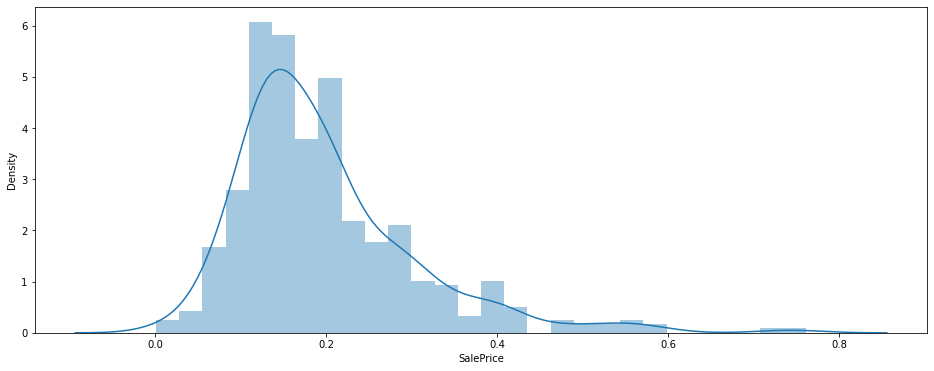

In [57]:
#Distribution of Target Variable
plt.figure(figsize=(16,6))
sns.distplot(df_test.SalePrice)
plt.show()

In [58]:
y_train=df_train.pop('SalePrice')
X_train=df_train

In [59]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [60]:
y_test

500     0.108457
1265    0.206916
414     0.268157
1050    0.196619
1037    0.350090
          ...   
325     0.072351
1290    0.202194
728     0.104291
541     0.295931
135     0.193168
Name: SalePrice, Length: 437, dtype: float64

In [61]:
X_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
500,0.823529,0.000000,0.008494,0.555556,0.500,0.206821,0.135274,0.209607,0.0,0.203593,...,0,0,0,1,0,0,0,0,1,0
1265,0.823529,0.047945,0.035056,0.666667,0.500,0.158200,0.103168,0.215533,0.0,0.257485,...,0,0,0,1,0,0,0,0,1,0
414,0.235294,0.130137,0.142929,0.666667,0.500,0.000000,0.213613,0.336868,0.0,0.406034,...,0,0,0,1,0,0,0,0,1,0
1050,0.000000,0.178082,0.110753,0.666667,0.500,0.000000,0.557363,0.406114,0.0,0.222939,...,0,1,0,0,0,0,0,0,0,1
1037,0.235294,0.167808,0.114309,0.777778,0.500,0.287373,0.451627,0.329070,0.0,0.444265,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.147059,0.099315,0.053267,0.444444,0.625,0.000000,0.258562,0.224579,0.0,0.108015,...,0,0,0,1,0,0,0,0,1,0
1290,0.352941,0.178082,0.184449,0.444444,0.750,0.062409,0.059075,0.359326,0.0,0.188392,...,0,0,0,1,0,0,0,0,1,0
728,0.411765,0.219178,0.146485,0.444444,0.500,0.068940,0.678082,0.494074,0.0,0.332105,...,0,0,0,0,1,0,0,0,0,0
541,0.235294,0.239726,0.139647,0.777778,0.500,0.052250,0.414812,0.302246,0.0,0.449332,...,0,0,0,1,0,0,0,0,1,0


In [62]:
# Using RFE to find top 300 variables
rfe = RFE(estimator=Ridge(), n_features_to_select=300)
rfe = rfe.fit(X_train,y_train)
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_test_rfe = X_test[col]

In [63]:
#Calculating r2score,RSS,RMSE
y_pred_train=rfe.predict(X_train_rfe)
y_pred_test=rfe.predict(X_test_rfe)

metric=[]
r2_train_lr=r2_score(y_train,y_pred_train)
print("Rsquare Train:",r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr=r2_score(y_test,y_pred_test)
print("Rsquare Test:",r2_test_lr)
metric.append(r2_test_lr)

rss1_lr=np.sum(np.square(y_train-y_pred_train))
print("RSS Train:",rss1_lr)
metric.append(rss1_lr)

rss2_lr=np.sum(np.square(y_test-y_pred_test))
print("RSS Test:",rss2_lr)
metric.append(rss2_lr)

mse_train_lr=mean_squared_error(y_train,y_pred_train)
print("MSE Train:",mse_train_lr)
metric.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE Test:",mse_test_lr)
metric.append(mse_test_lr)

rmse_train_lr=mean_squared_error(y_train,y_pred_train)
print("RMSE Train:",rmse_train_lr**0.5)
metric.append(rmse_train_lr**0.5)

rmse_test_lr = mean_squared_error(y_test, y_pred_test)
print("RMSE Test:",rmse_test_lr**0.5)
metric.append(rmse_test_lr**0.5)

Rsquare Train: 0.9286735985472135
Rsquare Test: 0.8888863685129371
RSS Train: 0.9055490334227102
RSS Test: 0.5471437614814382
MSE Train: 0.0008895373609260415
MSE Test: 0.0012520452207813232
RMSE Train: 0.029825112923944505
RMSE Test: 0.03538425102755918


#### Checking for assumptions

In [64]:
### Residual analysis
y_train_res=y_train-y_pred_train

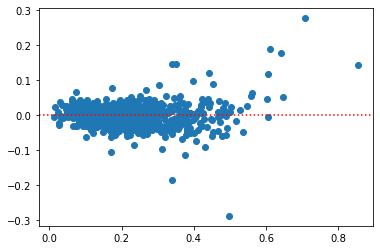

In [65]:
# Residual v/s prediction plot
y_train_res
plt.axhline(y=0, color='r', linestyle=':')
plt.scatter(y_pred_train,y_train_res)

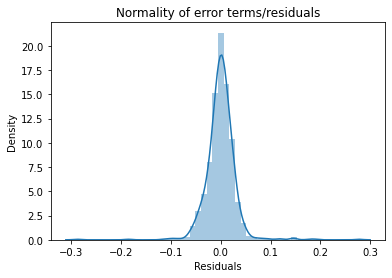

In [66]:
# Distribution of errors
p = sns.distplot(y_train_res,kde=True)

p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

In [67]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()

# cross validation
folds = 11
model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

Fitting 11 folds for each of 28 candidates, totalling 308 fits


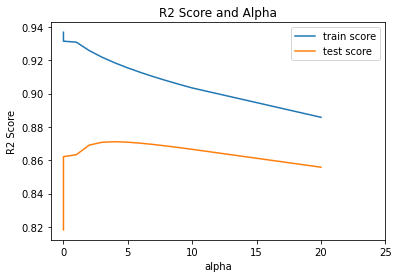

The optimum alpha is 4
The R2 Score of the model on the test dataset for optimum alpha is 0.8948718225667838
The RSS Score of the model on the test dataset for optimum alpha is 0.9055490334227102
The MSE of the model on the test dataset for optimum alpha is 0.001184600218381258
The RMSE of the model on the test dataset for optimum alpha is 0.03441802170929146
{'alpha': 4.0}


In [68]:
# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,30,5))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
ridge_final = Ridge(alpha=alpha)
ridge_final.fit(X_train_rfe,y_train)
ridge_coef = ridge_final.coef_
y_test_pred = ridge_final.predict(X_test_rfe)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The RSS Score of the model on the test dataset for optimum alpha is',np.sum(np.square(y_train-y_pred_train)))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))
print('The RMSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred)**0.5)
print(model_cv.best_params_)

In [69]:
# Chekcing the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
high_vif = vif[vif['VIF']>10]
high_vif

,Features,VIF
126,Exterior1st_VinylSd,inf
174,BsmtExposure_Mn,inf
161,Foundation_Slab,inf
162,Foundation_Stone,inf
163,Foundation_Wood,inf
...,...,...
95,HouseStyle_1Story,inf
96,HouseStyle_2.5Fin,inf
8,LowQualFinSF,inf
0,MSSubClass,31.76


In [70]:
# Dropping cols with high VIF
X_train_rfe2 = X_train_rfe.drop(high_vif.Features,axis=1)
X_test_rfe2 = X_test_rfe.drop(high_vif.Features,axis=1)

Fitting 11 folds for each of 28 candidates, totalling 308 fits


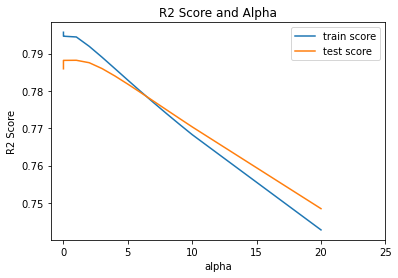

The optimum alpha is 1
The R2 Score of the model on the test dataset for optimum alpha is 0.8101113715051378
The R2 Score of the model on the test dataset for optimum alpha is 0.9055490334227102
The MSE of the model on the test dataset for optimum alpha is 0.0021396938125939455
The RMSE of the model on the test dataset for optimum alpha is 0.04625682449751545
{'alpha': 1.0}


In [71]:
# Building the second Ridge Model
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge(random_state=100)

# cross validation
folds = 11
model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe2, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,30,5))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
ridge_final2 = Ridge(alpha=alpha,random_state=100)
ridge_final2.fit(X_train_rfe2,y_train)
ridge_coef2 = ridge_final2.coef_
y_test_pred = ridge_final2.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The R2 Score of the model on the test dataset for optimum alpha is',np.sum(np.square(y_train-y_pred_train)))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))
print('The RMSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred)**0.5)
print(model_cv.best_params_)

In [72]:
# Creating a model with an arbitrary alpha to understand the value ranges
lasso1 = Lasso(alpha=0.0001)        
lasso1.fit(X_train_rfe2, y_train) 

y_test_pred = lasso1.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for 0.0001 alpha is',r2_score(y_test, y_test_pred))
print('The R2 Score of the model on the test dataset for optimum alpha is',np.sum(np.square(y_train-y_pred_train)))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))
print('The RMSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred)**0.5)

The R2 Score of the model on the test dataset for 0.0001 alpha is 0.8113380665945973
The R2 Score of the model on the test dataset for optimum alpha is 0.9055490334227102
The MSE of the model on the test dataset for optimum alpha is 0.002125871226619942
The RMSE of the model on the test dataset for optimum alpha is 0.046107171097562925


Fitting 11 folds for each of 11 candidates, totalling 121 fits


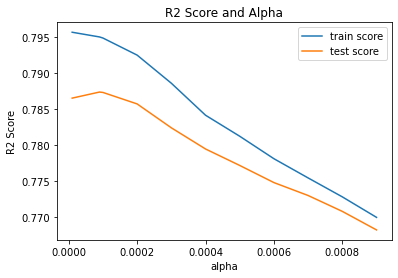

The optimum alpha is 9e-05
The R2 Score of the model on the test dataset for optimum alpha is 0.811446807427753
The R2 Score of the model on the test dataset for optimum alpha is 0.9055490334227102
The MSE of the model on the test dataset for optimum alpha is 0.0021246459184499694
The RMSE of the model on the test dataset for optimum alpha is 0.04609388157282883


In [73]:
# Builsing a Lasso Model with GridSearch CV to find the optimum alpha
params = {'alpha': [0.00001, 0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009 ]}
lasso = Lasso(random_state=100)

# cross validation
folds = 11
model_cv = GridSearchCV(estimator = lasso, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe2, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
lasso_final2 = Lasso(alpha=alpha,random_state=100)
lasso_final2.fit(X_train_rfe2,y_train)
lasso_coef2 = lasso_final2.coef_
y_test_pred = lasso_final2.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The R2 Score of the model on the test dataset for optimum alpha is',np.sum(np.square(y_train-y_pred_train)))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))
print('The RMSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred)**0.5)


In [74]:
#Displaing the co-efficients of the model
lasso_coeff2 = pd.DataFrame(np.atleast_2d(lasso_coef2),columns=X_train_rfe2.columns)
lasso_coeff2 = lasso_coeff2.T
lasso_coeff2.rename(columns={0: "Lasso Co-Efficient"},inplace=True)
lasso_coeff2.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
lasso_coeff2.head(20)

,Lasso Co-Efficient
OverallQual,0.267129
TotRmsAbvGrd,0.162143
LotArea,0.142846
MasVnrArea,0.104366
Total_Bathrooms,0.103513
GarageArea,0.071487
LotFrontage,0.070899
Fireplaces,0.051074
Total_porch_sf,0.030050
OverallCond,0.025172


In [75]:
model_cv.best_params_

{'alpha': 9e-05}

In [76]:
print("Ridge optimal value of alpha:",ridge_final2)
print("Lasso optimal value of alpha:",lasso_final2)


Ridge optimal value of alpha: Ridge(alpha=1, random_state=100)
Lasso optimal value of alpha: Lasso(alpha=9e-05, random_state=100)


#### We are able achive R2(squared value) both lasso and ridge regression

* OverallQual
* TotRmsAbvGrd
*  LotArea
* MasVnrArea
* Total_Bathrooms
* GarageArea
* LotFrontage
* Fireplaces
* Total_porch_sf
* OverallCond
* GarageCars

#### Subjectives Questions

In [77]:
# Building Ridge Model by doubling the value of alpha to 2
ridge_double = Ridge(alpha=2,random_state=100)
ridge_double.fit(X_train_rfe2,y_train)
ridge_double_coef = ridge_double.coef_
y_test_pred = ridge_double.predict(X_test_rfe2)
ridge_double_coeff = pd.DataFrame(np.atleast_2d(ridge_double_coef),columns=X_train_rfe2.columns)
ridge_double_coeff = ridge_double_coeff.T
ridge_double_coeff.rename(columns={0: 'Ridge Doubled Alpha Co-Efficient'},inplace=True)
ridge_double_coeff.sort_values(by=['Ridge Doubled Alpha Co-Efficient'], ascending=False,inplace=True)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The R2 Score of the model on the test dataset for optimum alpha is',np.sum(np.square(y_train-y_pred_train)))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))
print('The RMSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred)**0.5)
print('The most important predictor variables are as follows:')
ridge_double_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.8077432143731696
The R2 Score of the model on the test dataset for optimum alpha is 0.9055490334227102
The MSE of the model on the test dataset for doubled alpha is 0.0021663785656657153
The RMSE of the model on the test dataset for optimum alpha is 0.046544372008500826
The most important predictor variables are as follows:


,Ridge Doubled Alpha Co-Efficient
OverallQual,0.235515
TotRmsAbvGrd,0.141937
LotArea,0.116859
MasVnrArea,0.105338
Total_Bathrooms,0.102107
LotFrontage,0.073532
GarageArea,0.067169
Fireplaces,0.059936
Total_porch_sf,0.036773
GarageCars,0.034363


In [78]:
# Building Lasso Model by doubling the value of alpha to 0.0009
lasso_double = Lasso(alpha=0.0018,random_state=100)
lasso_double.fit(X_train_rfe2,y_train)
lasso_double_coef = lasso_double.coef_
y_test_pred = lasso_double.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))
print('The RMSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred)**0.5)
lasso_double_coeff = pd.DataFrame(np.atleast_2d(lasso_double_coef),columns=X_train_rfe2.columns)
lasso_double_coeff = lasso_double_coeff.T
lasso_double_coeff.rename(columns={0: 'Lasso Doubled Alpha Co-Efficient'},inplace=True)
lasso_double_coeff.sort_values(by=['Lasso Doubled Alpha Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
lasso_double_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.7597180861440773
The MSE of the model on the test dataset for doubled alpha is 0.002707532980942353
The RMSE of the model on the test dataset for optimum alpha is 0.05203395988143083
The most important predictor variables are as follows:


,Lasso Doubled Alpha Co-Efficient
OverallQual,0.270385
Total_Bathrooms,0.086175
Fireplaces,0.066102
TotRmsAbvGrd,0.059513
GarageArea,0.055202
GarageCars,0.043245
MasVnrArea,0.042675
Total_porch_sf,0.004987
LotFrontage,0.000000
YrSold_Old,-0.000000


In [80]:
#Removing the 5 most important predictor variables from the incoming dataset
X_test_rfe3 = X_test_rfe2.drop(['OverallQual','Total_Bathrooms','Fireplaces','TotRmsAbvGrd','GarageArea'],axis=1)
X_train_rfe3 = X_train_rfe2.drop(['OverallQual','Total_Bathrooms','Fireplaces','TotRmsAbvGrd','GarageArea'],axis=1)

# Building Lasso Model with the new dataset
lasso3 = Lasso(alpha=0.0001,random_state=100)
lasso3.fit(X_train_rfe3,y_train)
lasso3_coef = lasso3.coef_
y_test_pred = lasso3.predict(X_test_rfe3)
print('The R2 Score of the model on the test dataset is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset is', mean_squared_error(y_test, y_test_pred))
lasso3_coeff = pd.DataFrame(np.atleast_2d(lasso3_coef),columns=X_train_rfe3.columns)
lasso3_coeff = lasso3_coeff.T
lasso3_coeff.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso3_coeff.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
lasso3_coeff.head(5)

The R2 Score of the model on the test dataset is 0.6683695043584168
The MSE of the model on the test dataset is 0.00373686262951211
The most important predictor variables are as follows:


,Lasso Co-Efficient
MasVnrArea,0.220553
GarageCars,0.191974
LotArea,0.185439
LotFrontage,0.133628
Total_porch_sf,0.103080
